# Sentiment analysis : Model Training and Prediction 

Here we will walk through the process of training sentiment analysis models for different sources and making predictions.

In [ ]:
# import neccessary libraries
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import re 
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pkkar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pkkar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pkkar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
train_data= pd.read_csv("C:/sentiment analysis/data/twitter_training.csv",names=['serial_number','source','sentiment','text'])
val_data= pd.read_csv("C:/sentiment analysis/data/twitter_validation.csv",names=['serial_number','source','sentiment','text'])

In [4]:
print(f"Training data shape:{train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"\nTraining data sample:")
display(train_data.head())

Training data shape:(74682, 4)
Validation data shape: (1000, 4)

Training data sample:


,serial_number,source,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
train_data['sentiment'].value_counts()

sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [6]:
def preprocess_text(text):
    text=str(text).lower()
    text=re.sub(r'[^a-zA-Z\s]','',text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)
    
    

In [7]:
train_data['processed_text'] = train_data['text'].apply(preprocess_text)

In [8]:
display(train_data[['text','processed_text']])

,text,processed_text
0,im getting on borderlands and i will murder yo...,im getting borderlands murder
1,I am coming to the borders and I will kill you...,coming borders kill
2,im getting on borderlands and i will kill you ...,im getting borderlands kill
3,im coming on borderlands and i will murder you...,im coming borderlands murder
4,im getting on borderlands 2 and i will murder ...,im getting borderlands murder
...,...,...
74677,Just realized that the Windows partition of my...,realized windows partition mac like years behi...
74678,Just realized that my Mac window partition is ...,realized mac window partition years behind nvi...
74679,Just realized the windows partition of my Mac ...,realized windows partition mac years behind nv...
74680,Just realized between the windows partition of...,realized windows partition mac like years behi...


In [9]:
val_data['processed_text'] = val_data['text'].apply(preprocess_text)
display(val_data[['text','processed_text']].head())

,text,processed_text
0,I mentioned on Facebook that I was struggling ...,mentioned facebook struggling motivation go ru...
1,BBC News - Amazon boss Jeff Bezos rejects clai...,bbc news amazon boss jeff bezos rejects claims...
2,@Microsoft Why do I pay for WORD when it funct...,microsoft pay word functions poorly samsungus ...
3,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking full closet hacking truly awf...
4,Now the President is slapping Americans in the...,president slapping americans face really commi...


In [10]:
import os 

In [11]:
! pip install joblib

In [12]:
import joblib

## Model 1 (Linear support vector classifier)

In [13]:
def train_source_model(source_data):
    x= source_data['processed_text']
    y= source_data['sentiment']
    
    
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    x=tfidf_vectorizer.fit_transform(x)
    
    model = LinearSVC()
    model.fit(x,y)
    
    return model , tfidf_vectorizer

# train models for each source 
sources = train_data['source'].unique()

if not os.path.exists('models'):
    os.makedirs('models')
    
    
for source in sources :
    print(f"training model for source: {source}")
    source_data = train_data[train_data['source']== source]
    model , vectorizer = train_source_model(source_data)
    
    
    # save the model and vectorizer 
    joblib.dump(model,f'models/{source}_model.joblib')
    joblib.dump(vectorizer,f'models/{source}_vectorizer.joblib')
    
    
    
    
print("training completed models saved in 'models' directory ")
    
    

training model for source: Borderlands
training model for source: CallOfDutyBlackopsColdWar
training model for source: Amazon
training model for source: Overwatch
training model for source: Xbox(Xseries)
training model for source: NBA2K
training model for source: Dota2
training model for source: PlayStation5(PS5)
training model for source: WorldOfCraft
training model for source: CS-GO
training model for source: Google
training model for source: AssassinsCreed
training model for source: ApexLegends
training model for source: LeagueOfLegends
training model for source: Fortnite
training model for source: Microsoft
training model for source: Hearthstone
training model for source: Battlefield
training model for source: PlayerUnknownsBattlegrounds(PUBG)
training model for source: Verizon
training model for source: HomeDepot
training model for source: FIFA
training model for source: RedDeadRedemption(RDR)
training model for source: CallOfDuty
training model for source: TomClancysRainbowSix
tr

In [14]:
def predict_sentiment(text,source):
    model = joblib.load(f'models/{source}_model.joblib')
    vectorizer = joblib.load(f'models/{source}_vectorizer.joblib')
    processed_text  = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]
    return prediction 


# Evaluate on validation set 
val_predictions = []
for _ , row in val_data.iterrows():
    pred = predict_sentiment(row['text'],row['source'])
    val_predictions.append(pred)
    
    
# print classification report 
print(classification_report(val_data['sentiment'],val_predictions ))

              precision    recall  f1-score   support

  Irrelevant       0.99      0.98      0.99       172
    Negative       0.98      0.98      0.98       266
     Neutral       0.99      0.99      0.99       285
    Positive       0.98      0.98      0.98       277

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [15]:
from sklearn.metrics import accuracy_score 
print (accuracy_score(val_data['sentiment'],val_predictions))

0.986


In [16]:
! pip install seaborn 

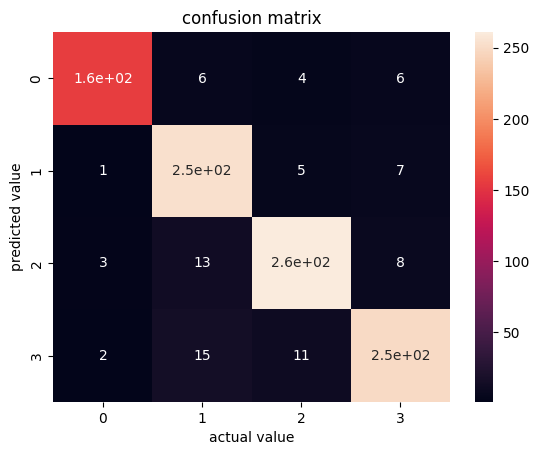

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
cm = confusion_matrix(val_data['sentiment'],val_predictions)
sns.heatmap(cm,annot=True)
plt.title("confusion matrix")
plt.xlabel("actual value")
plt.ylabel("predicted value")
plt.show()

In [18]:
sample_texts = [
    ("I love playing Borderlands! Can't wait to kill some skags!", "Borderlands"),
    ("This new graphics card is amazing!","Nvidia"),
    ("Facebook's new privacy policy is concerning.","Facebook"),
    ("The latest Windows update broke my computer.","Microsoft")
]


for text , source in sample_texts:
    try:
        sentiment = predict_sentiment(text,source)
        print(f"Text:'{text}'")
        print(f"Source: {source}")
        print(f"Pridicted sentiment : {sentiment}\n")
    except FileNotFoundError as e : 
        print(e)
        print(f"Text: '{text}'")
        print(f"Source: {source}")
        print(f"Pridicted sentiment : Unable to predict (model not found )\n")
        
    

Text:'I love playing Borderlands! Can't wait to kill some skags!'
Source: Borderlands
Pridicted sentiment : Positive

Text:'This new graphics card is amazing!'
Source: Nvidia
Pridicted sentiment : Positive

Text:'Facebook's new privacy policy is concerning.'
Source: Facebook
Pridicted sentiment : Neutral

Text:'The latest Windows update broke my computer.'
Source: Microsoft
Pridicted sentiment : Negative



In [19]:
# Print class distribution
print("\nClass Distribution in Validation Set:")
print(val_data['sentiment'].value_counts())




Class Distribution in Validation Set:
sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64


## Model 2 (Random forest classifier)

In [20]:
def train_source_model(source_data):
    x= source_data['processed_text']
    y= source_data['sentiment']
    
    
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    x=tfidf_vectorizer.fit_transform(x)
    
    model2 = RandomForestClassifier()
    model2.fit(x,y)
    
    return model2 , tfidf_vectorizer

# train models for each source 
sources = train_data['source'].unique()

if not os.path.exists('models2'):
    os.makedirs('models2')
    
    
for source in sources :
    print(f"training model for source: {source}")
    source_data = train_data[train_data['source']== source]
    model , vectorizer = train_source_model(source_data)
    
    
    # save the model and vectorizer 
    joblib.dump(model,f'models2/{source}_model.joblib')
    joblib.dump(vectorizer,f'models2/{source}_vectorizer.joblib')
    
    
    
    
print("training completed models saved in 'models2' directory ")

training model for source: Borderlands
training model for source: CallOfDutyBlackopsColdWar
training model for source: Amazon
training model for source: Overwatch
training model for source: Xbox(Xseries)
training model for source: NBA2K
training model for source: Dota2
training model for source: PlayStation5(PS5)
training model for source: WorldOfCraft
training model for source: CS-GO
training model for source: Google
training model for source: AssassinsCreed
training model for source: ApexLegends
training model for source: LeagueOfLegends
training model for source: Fortnite
training model for source: Microsoft
training model for source: Hearthstone
training model for source: Battlefield
training model for source: PlayerUnknownsBattlegrounds(PUBG)
training model for source: Verizon
training model for source: HomeDepot
training model for source: FIFA
training model for source: RedDeadRedemption(RDR)
training model for source: CallOfDuty
training model for source: TomClancysRainbowSix
tr

In [21]:
def predict_sentiment(text,source):
    model = joblib.load(f'models2/{source}_model.joblib')
    vectorizer = joblib.load(f'models2/{source}_vectorizer.joblib')
    processed_text  = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]
    return prediction 


# Evaluate on validation set 
val_predictions = []
for _ , row in val_data.iterrows():
    pred = predict_sentiment(row['text'],row['source'])
    val_predictions.append(pred)
    
    
# print classification report 
print(classification_report(val_data['sentiment'],val_predictions ))
accuracy_of_model2=accuracy_score(val_data['sentiment'],val_predictions)
print(f"accuracy_of_model2 : {accuracy_of_model2}")

              precision    recall  f1-score   support

  Irrelevant       0.98      0.96      0.97       172
    Negative       0.95      0.98      0.96       266
     Neutral       0.98      0.95      0.97       285
    Positive       0.97      0.97      0.97       277

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

accuracy_of_model2 : 0.967


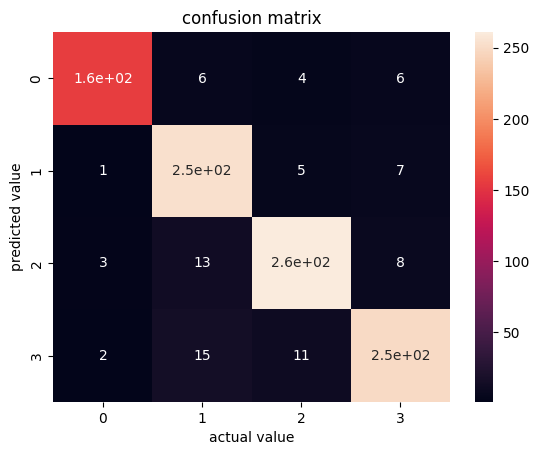

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
cm = confusion_matrix(val_data['sentiment'],val_predictions)
sns.heatmap(cm,annot=True)
plt.title("confusion matrix")
plt.xlabel("actual value")
plt.ylabel("predicted value")
plt.show()

In [23]:
! pip install matplotlib

In [27]:
# Print detailed class distribution and model predictions
print("\nDetailed Analysis:")
print("\n1. Validation Data Class Distribution:")
print(val_data['sentiment'].value_counts())

print("\n2. Model Predictions Distribution:")
print(pd.Series(val_predictions).value_counts())




Detailed Analysis:

1. Validation Data Class Distribution:
sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64

2. Model Predictions Distribution:
Positive      279
Neutral       277
Negative      275
Irrelevant    169
Name: count, dtype: int64


## Model 3 (Decision Tree Classifier)

In [30]:
def train_source_model(source_data):
    x= source_data['processed_text']
    y= source_data['sentiment']
    
    
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    x=tfidf_vectorizer.fit_transform(x)
    
    model3 = DecisionTreeClassifier()
    model3.fit(x,y)
    
    return model3 , tfidf_vectorizer

# train models for each source 
sources = train_data['source'].unique()

if not os.path.exists('models3'):
    os.makedirs('models3')
    
    
for source in sources :
    print(f"training model for source: {source}")
    source_data = train_data[train_data['source']== source]
    model , vectorizer = train_source_model(source_data)
    
    
    # save the model and vectorizer 
    joblib.dump(model,f'models3/{source}_model.joblib')
    joblib.dump(vectorizer,f'models3/{source}_vectorizer.joblib')
    
    
    
    
print("training completed models saved in 'models3' directory ")

training model for source: Borderlands
training model for source: CallOfDutyBlackopsColdWar
training model for source: Amazon
training model for source: Overwatch
training model for source: Xbox(Xseries)
training model for source: NBA2K
training model for source: Dota2
training model for source: PlayStation5(PS5)
training model for source: WorldOfCraft
training model for source: CS-GO
training model for source: Google
training model for source: AssassinsCreed
training model for source: ApexLegends
training model for source: LeagueOfLegends
training model for source: Fortnite
training model for source: Microsoft
training model for source: Hearthstone
training model for source: Battlefield
training model for source: PlayerUnknownsBattlegrounds(PUBG)
training model for source: Verizon
training model for source: HomeDepot
training model for source: FIFA
training model for source: RedDeadRedemption(RDR)
training model for source: CallOfDuty
training model for source: TomClancysRainbowSix
tr

In [32]:
def predict_sentiment(text,source):
    model = joblib.load(f'models3/{source}_model.joblib')
    vectorizer = joblib.load(f'models3/{source}_vectorizer.joblib')
    processed_text  = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]
    return prediction 


# Evaluate on validation set 
val_predictions = []
for _ , row in val_data.iterrows():
    pred = predict_sentiment(row['text'],row['source'])
    val_predictions.append(pred)
    
    
# print classification report 
print(classification_report(val_data['sentiment'],val_predictions ))
accuracy_of_model3=accuracy_score(val_data['sentiment'],val_predictions)
print(f"accuracy_of_model3 : {accuracy_of_model3}")

              precision    recall  f1-score   support

  Irrelevant       0.96      0.91      0.93       172
    Negative       0.88      0.95      0.92       266
     Neutral       0.93      0.92      0.92       285
    Positive       0.92      0.90      0.91       277

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

accuracy_of_model3 : 0.919


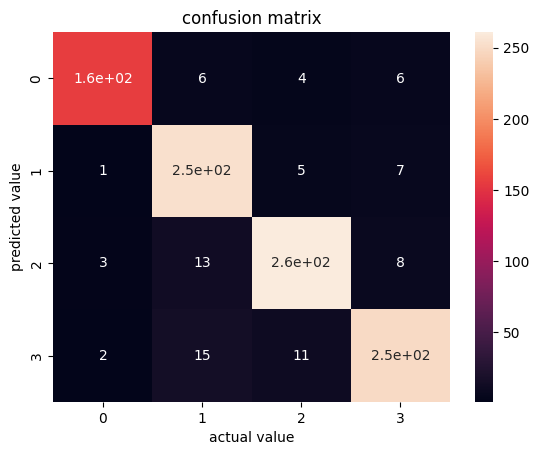

In [35]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
cm = confusion_matrix(val_data['sentiment'],val_predictions)
sns.heatmap(cm,annot=True)
plt.title("confusion matrix")
plt.xlabel("actual value")
plt.ylabel("predicted value")
plt.show()

## Model 4 (KNN classifier)

In [40]:
def train_source_model(source_data):
    x= source_data['processed_text']
    y= source_data['sentiment']
    
    
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    x=tfidf_vectorizer.fit_transform(x)
    
    model4 = KNeighborsClassifier(n_neighbors=5,weights='uniform')
    model4.fit(x,y)
    
    return model4 , tfidf_vectorizer

# train models for each source 
sources = train_data['source'].unique()

if not os.path.exists('models4'):
    os.makedirs('models4')
    
    
for source in sources :
    print(f"training model for source: {source}")
    source_data = train_data[train_data['source']== source]
    model , vectorizer = train_source_model(source_data)
    
    
    # save the model and vectorizer 
    joblib.dump(model,f'models4/{source}_model.joblib')
    joblib.dump(vectorizer,f'models4/{source}_vectorizer.joblib')
    
    
    
    
print("training completed models saved in 'models4' directory ")

training model for source: Borderlands
training model for source: CallOfDutyBlackopsColdWar
training model for source: Amazon
training model for source: Overwatch
training model for source: Xbox(Xseries)
training model for source: NBA2K
training model for source: Dota2
training model for source: PlayStation5(PS5)
training model for source: WorldOfCraft
training model for source: CS-GO
training model for source: Google
training model for source: AssassinsCreed
training model for source: ApexLegends
training model for source: LeagueOfLegends
training model for source: Fortnite
training model for source: Microsoft
training model for source: Hearthstone
training model for source: Battlefield
training model for source: PlayerUnknownsBattlegrounds(PUBG)
training model for source: Verizon
training model for source: HomeDepot
training model for source: FIFA
training model for source: RedDeadRedemption(RDR)
training model for source: CallOfDuty
training model for source: TomClancysRainbowSix
tr

In [41]:
def predict_sentiment(text,source):
    model = joblib.load(f'models4/{source}_model.joblib')
    vectorizer = joblib.load(f'models4/{source}_vectorizer.joblib')
    processed_text  = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]
    return prediction 


# Evaluate on validation set 
val_predictions = []
for _ , row in val_data.iterrows():
    pred = predict_sentiment(row['text'],row['source'])
    val_predictions.append(pred)
    
    
# print classification report 
print(classification_report(val_data['sentiment'],val_predictions ))
accuracy_of_model4=accuracy_score(val_data['sentiment'],val_predictions)
print(f"accuracy_of_model4 : {accuracy_of_model4}")

              precision    recall  f1-score   support

  Irrelevant       0.97      0.99      0.98       172
    Negative       0.94      0.98      0.96       266
     Neutral       0.99      0.95      0.97       285
    Positive       0.99      0.97      0.98       277

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

accuracy_of_model4 : 0.971


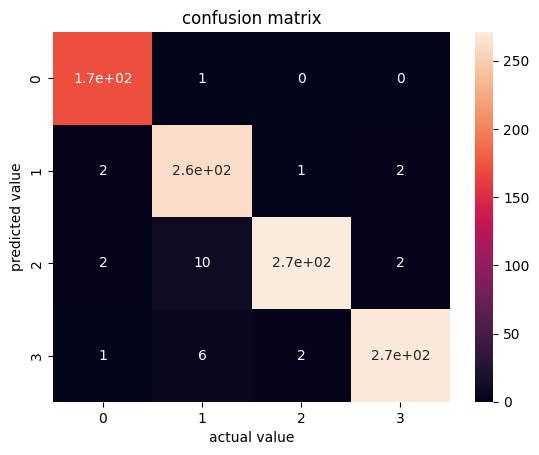

In [42]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
cm = confusion_matrix(val_data['sentiment'],val_predictions)
sns.heatmap(cm,annot=True)
plt.title("confusion matrix")
plt.xlabel("actual value")
plt.ylabel("predicted value")
plt.show()

## Model 5 (XGboost)

In [47]:
! pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.8/124.9 MB 4.8 MB/s eta 0:00:27
    --------------------------------------- 2.1/124.9 MB 5.1 MB/s eta 0:00:25
    --------------------------------------- 2.9/124.9 MB 5.2 MB/s eta 0:00:24
   - -------------------------------------- 3.9/124.9 MB 4.8 MB/s eta 0:00:26
   - -------------------------------------- 5.0/124.9 MB 4.9 MB/s eta 0:00:25
   - -------------------------------------- 6.0/124.9 MB 4.9 MB/s eta 0:00:25
   -- ------------------------------------- 6.8/124.9 MB 4.8 MB/s eta 0:00:25
   -- ------------------------------------- 7.9/124.9 MB 4.7 MB/s eta 0:00:26
   -- ------------------------------------- 8.7/124.9 MB 4.6 MB/s eta 0:00:26
   --- ------------------------------------ 9.4/124.9 MB 4.6 MB/s eta 0:00:26
   --- ------------------------------------ 10.5/124.9 MB 4.6 MB/s eta 0:00:25
   --- ------------------------------------ 11.3/124.9 MB 4.5 MB/s eta

In [48]:
from xgboost import XGBClassifier

In [51]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [54]:
def train_source_model(source_data):
    x= source_data['processed_text']
    y= encoder.fit_transform(source_data['sentiment'])
    
    
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    x=tfidf_vectorizer.fit_transform(x)
    
    model5 = XGBClassifier()
    model5.fit(x,y)
    
    return model5 , tfidf_vectorizer

# train models for each source 
sources = train_data['source'].unique()

if not os.path.exists('models5'):
    os.makedirs('models5')
    
    
for source in sources :
    print(f"training model for source: {source}")
    source_data = train_data[train_data['source']== source]
    model , vectorizer = train_source_model(source_data)
    
    
    # save the model and vectorizer 
    joblib.dump(model,f'models5/{source}_model.joblib')
    joblib.dump(vectorizer,f'models5/{source}_vectorizer.joblib')
    
    
    
    
print("training completed models saved in 'models5' directory ")

training model for source: Borderlands
training model for source: CallOfDutyBlackopsColdWar
training model for source: Amazon
training model for source: Overwatch
training model for source: Xbox(Xseries)
training model for source: NBA2K
training model for source: Dota2
training model for source: PlayStation5(PS5)
training model for source: WorldOfCraft
training model for source: CS-GO
training model for source: Google
training model for source: AssassinsCreed
training model for source: ApexLegends
training model for source: LeagueOfLegends
training model for source: Fortnite
training model for source: Microsoft
training model for source: Hearthstone
training model for source: Battlefield
training model for source: PlayerUnknownsBattlegrounds(PUBG)
training model for source: Verizon
training model for source: HomeDepot
training model for source: FIFA
training model for source: RedDeadRedemption(RDR)
training model for source: CallOfDuty
training model for source: TomClancysRainbowSix
tr

In [62]:
def predict_sentiment(text,source):
    model = joblib.load(f'models5/{source}_model.joblib')
    vectorizer = joblib.load(f'models5/{source}_vectorizer.joblib')
    processed_text  = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]
    return prediction 


# Evaluate on validation set 
val_predictions = []
for _ , row in val_data.iterrows():
    pred = predict_sentiment(row['text'],row['source'])
    val_predictions.append(pred)
    
    
# print classification report 
print(classification_report(encoder.fit_transform(val_data['sentiment']),val_predictions ))
accuracy_of_model5=accuracy_score(encoder.fit_transform(val_data['sentiment']),val_predictions)
print(f"accuracy_of_model5 : {accuracy_of_model5}")

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       172
           1       0.97      0.98      0.98       266
           2       0.97      0.95      0.96       285
           3       0.95      0.97      0.96       277

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

accuracy_of_model5 : 0.968


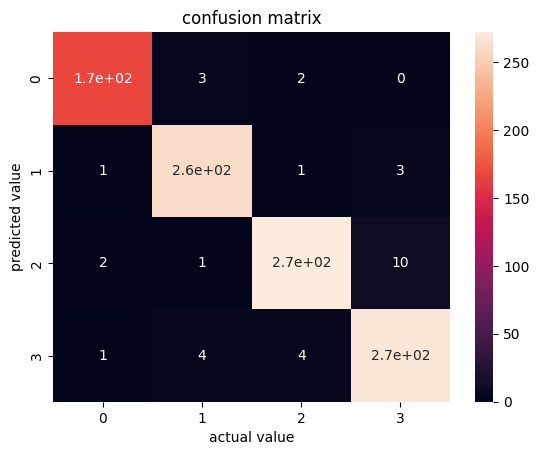

In [63]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
cm = confusion_matrix(encoder.fit_transform(val_data['sentiment']),val_predictions)
sns.heatmap(cm,annot=True)
plt.title("confusion matrix")
plt.xlabel("actual value")
plt.ylabel("predicted value")
plt.show()

## **Project End** 